Relatório do trabalho
==============
**Nome:** Álvaro Leandro Cavalcante Carneiro
**Linguagem utilizada:** Python 3.6


**Matéria**: Computação Inspirada na Natureza

**Professor**: Prof. Dr. Fabricio Breve

Os códigos e o relatório foram desenvolvidos em um Jupyter notebook, portanto cada tópico possui a explicação e o contexto necessário do código que se segue.

# Qual o problema?
O primeiro problema baseia-se em utilizar o algoritmo *particle swarm optimization (PSO)* para otimização de uma função matemática.

## Importação das bibliotecas
O primeiro passo em toda a codificação é a importação das bibliotecas que serão utilizadas no desenvolvimento dos algoritmos aqui propostos.

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import math
import itertools

## Função de aptidão
A função de aptidão será a responsável por fazer a avaliação da solução proposta pelo algoritmo e que deve nortear a convergência do mesmo, para maximização ou minimização do valor retornado. 

A implementação nesse caso é basicamente a fórmula matemática que se tem interesse em otimizar, tendo por **objetivo** a minimização do valor retornado.

In [60]:
def funcao_aptidao(x, y):
    return (1 - x)**2 + 100*(y-x**2)**2

## Enxame de indivíduos
Foi criado o método de *get_enxame* para criação do enxame inicial de partículas. Cada partícula possui valores aleatórios dentro do **domínio do problema ([-5, 5] nesse caso)**. Nesse método, para cada partícula um valor aleatório é atribuído para cada uma de suas dimensões, uma vez que esse problema é bidimensional, com as variáveis x e y a serem otimizadas. 

In [61]:
def get_enxame(n_particulas, dominio):
    enxame = []

    for i in range(n_particulas): # cria o número determinado de partículas
        # cada partícula recebe um valor aleatório no domínio para cada uma de suas dimensões.
        particula = [random.uniform(dominio[i][0], dominio[i][1]) for i in range(len(dominio))]
        enxame.append(particula)
    
    return enxame

## Velocidade inicial das partículas
As partículas começam com uma velocidade inicial aleatória para percorrer o espaço de busca, portanto foi criado o método *get_velocidade* que vai criar um valor de velocidade para cada partícula baseado no domínio mínimo e máximo permitidos, sendo para esse problema [-2, 2].

In [62]:
def get_velocidade(n_particulas, dominio):
    velocidade = []
    for i in range(n_particulas):
        velocidade.append(random.uniform(dominio[0], dominio[len(dominio) - 1]))
    
    return velocidade

## Atualização da velocidade
O método *atualizar_velocidade* é um dos mais importantes no PSO, pois aplica a fórmula que faz a atualização da velocidade das partículas no espaço, controlando a convergência do algoritmo. 

Para que a fórmula seja aplicada, esse método precisa pegar também os vizinhos de cada partícula que está sendo atualizada dentro do laço de repetição *for*, para ser utilizado na parte "social" do cálculo. Para isso, está sendo considerado uma vizinhança circular, onde a partícula na posição X do array é vizinha da partícula na posição X-1 e X+1. 
Essa vizinhança pode ser inclusive um parâmetro a ser levado em consideração na otimização do algoritmo, aumentando ou diminuindo o círculo de influência das partículas no enxame. 

Uma vez definido a partícula vizinha, é calculado a inteligência cognitiva e social da partícula e somadas para serem usadas como a nova velocidade, contanto que não ultrapassem os domínios de velocidade anteriomente definidos. Caso a velocidade seja maior que o domínio, então a velocidade recebe o valor máximo do domínio.

In [63]:
def atualizar_velocidade(v_atual, p_atual, melhor_p_particula, aptidao, 
                         dominio_v, dominio_particulas, ac1 = 2.05, ac2 = 2.05):
      
    v_nova = []
    count = 0

    for velocidade in v_atual:
        # criação do array de valores aleatórios, de 0 até o valor de ac para cada dimensão.
        v_aleatorio1 = [random.uniform(0, ac1) for i in range(len(dominio_particulas))]
        v_aleatorio2 = [random.uniform(0, ac2) for i in range(len(dominio_particulas))]
        
        # encontrando qual o melhor vizinho
        proximo_vizinho = count + 1 if count + 1 < len(aptidao) else 0
        melhor_p_vizinho = aptidao.index(min([aptidao[count - 1]] + [aptidao[proximo_vizinho]]))
        
        # pegando a melhor posição do melhor vizinho
        melhor_p_vizinho = melhor_p_particula[melhor_p_vizinho]

        # cálculo da inteligência cognitiva da partícula
        inteligencia_cognitiva = velocidade + (np.dot(v_aleatorio1, np.array(melhor_p_particula[count]) - np.array(p_atual[count]))) 
        # cálculo da inteligência social da partícula
        inteligencia_social = np.dot(v_aleatorio2, np.array(melhor_p_vizinho) - np.array(p_atual[count]))
        # atualização da velocidade (soma das duas inteligências)
        velocidade_atualizada = inteligencia_cognitiva + inteligencia_social

        # verifica se a nova velocidade está dentro de domínio e corrige o valor se necessário
        velocidade_atualizada = velocidade_atualizada if velocidade_atualizada <= dominio_v[1] else dominio_v[1]
        velocidade_atualizada = velocidade_atualizada if velocidade_atualizada >= dominio_v[0] else dominio_v[0]
     
        # adiciona o valor novo em uma lista que será retornada
        v_nova.append(velocidade_atualizada)
        
        count += 1 
    
    return v_nova

## Atualização de posição
A atualização da posição atual da partícula foi implementada no método *atualizar_posicao*, onde basicamente é calculado a posição atual da partícula somado à sua velocidade de movimento obtida no método anterior. É necessário antes apenas adicionar uma dimensão duplicada na velocidade com o método *stack* do *numpy*, para conseguir aplicar a somatória em todas as dimensões da partícula.

In [64]:
def atualizar_posicao(p_atual, velocidade):
    velocidade = np.stack((np.array(velocidade), np.array(velocidade)), axis=1) 
    nova_p = np.array(p_atual) + np.array(velocidade)
    
    return nova_p

Foi criado um método chamado *get_melhor_posicao*, responsável por calcular a nova aptidão das posições que foram atualizadas pelo movimento no espaço baseado em suas velocidades. Esse método também verifica as melhores aptidões e melhores posições encontradas por cada partícula no enxame, pois é uma informação utilizada posteriormente no cálculo de velocidade.

In [65]:
def get_melhor_posicao(enxame_anterior, enxame, aptidao_anterior):
    nova_aptidao = [funcao_aptidao(x, y) for x, y in enxame] # aptidão com as novas posições

    count = 0
    melhor_posicao = []
    melhor_aptidao = []

    for i in aptidao_anterior:
        # verifica se alguma das posições novas é melhor e substitui se for o caso
        melhor_posicao.append(enxame[count] if nova_aptidao[count] < aptidao_anterior[count] else enxame_anterior[count])
        # verifica se alguma das aptidões melhorou e substitui se for o caso
        melhor_aptidao.append(nova_aptidao[count] if nova_aptidao[count] < aptidao_anterior[count] else aptidao_anterior[count])
        count +=1
    
    return melhor_posicao, nova_aptidao, melhor_aptidao

## Convergência do algoritmo
Para exibir os resultados em termos de convergência do algoritmo foram criados dois métodos. Primeiro o *exibir_convergencia_total* que é responsável por mostrar a convergência de cada uma das partículas do enxame ao longo das iterações.
Para isso, a variável de convergência é convertida em uma matriz e depois é feita a sua transposição. Depois, um laço *for* percorre cada partícula e plota a sua convergência ao longo do tempo.

In [66]:
def exibir_convergencia_total(convergencia):
    matriz_convergencia = np.asmatrix(convergencia)
    matriz_convergencia = np.transpose(matriz_convergencia) # matriz transposta
    
    for i in matriz_convergencia:
        vetor = i.reshape(-1, 1)
        plt.plot(vetor) # adicionando a convergência de cada partícula na figura
    
    plt.show() # exibindo o gráfico

O segundo método foi o de *exibir_convergencia_minima_media*, que como o próprio nome sugere, mostra os gráficos da média e do valor mínimo das partículas do enxame ao longo das iterações.

In [67]:
def exibir_convergencia_minima_media(melhores_aptidoes, aptidao_media):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 8)) # iniciar a figura
    # plotar a figura de treinamento
    axes[0].plot(melhores_aptidoes, color = 'blue')
    axes[0].legend(['Melhor aptidão ao longo das iterações'])
    # plotar a figura de teste
    axes[1].plot(aptidao_media, color = 'orange')
    axes[1].legend(['Média de aptidão ao longo das iterações'])

    plt.xlabel('Execuções')
    plt.ylabel('Aptidão')
    plt.show()

## Implementação do PSO
O método *pso* é onde o processo de otimização e busca por melhores resultados é realizado de fato, aplicando todos os métodos que foram implementadas anteriormente. Os parâmetros passados e que devem ser ajustados para melhorar a performance do algoritmo são o número de partículas no enxame, o domínio das partículas, o domínio da velocidade e o número de execuções.

In [68]:
def pso(n_particulas, dominio_particulas, dominio_velocidade, execucoes = 30):
    enxame = get_enxame(n_particulas, dominio_particulas) # gera enxame inicial
    velocidade = get_velocidade(n_particulas, dominio_velocidade) # gera velocidade de cada particula

    melhor_p_particula = enxame # p indica posição
    enxame_anterior = []
    execucao = 0
    aptidoes = []
    melhores_aptidoes = []
    aptidao_media = []

    while execucao < execucoes:
        if len(enxame_anterior) == 0:
            # entra aqui na primeira vez
            aptidao = [funcao_aptidao(x, y) for x, y in enxame] # avalia as partículas
            velocidade = atualizar_velocidade(velocidade, enxame, melhor_p_particula,
                                        aptidao, dominio_velocidade, dominio_particulas)
        else:
            # as demais iterações passam por esse else
            melhor_p_particula, aptidao, melhor_aptidao = get_melhor_posicao(enxame_anterior,
                                                                             enxame, aptidao)            
            
            velocidade = atualizar_velocidade(velocidade, enxame, melhor_p_particula,
                                        melhor_aptidao, dominio_velocidade, dominio_particulas)
        
            aptidoes.append(melhor_aptidao)
            melhores_aptidoes.append(min(melhor_aptidao))
            aptidao_media.append(sum(melhores_aptidoes) / len(melhores_aptidoes))


        enxame_anterior = enxame.copy()
        enxame = atualizar_posicao(enxame, velocidade)
        
        execucao += 1
    
    # a melhor posição é calculada aqui na última iteração.
    melhor_p_particula, aptidao, melhor_aptidao = get_melhor_posicao(enxame_anterior, 
                                                                     enxame, aptidao)            

    return min(melhor_aptidao), melhor_p_particula[melhor_aptidao.index(min(melhor_aptidao))], aptidoes, \
    melhores_aptidoes, aptidao_media

## realização dos testes
O método *executar_pso* foi criado para facilitar os testes no algoritmo. Sua função é reexecutar o código por 30 vezes, para que seja possível capturar o desempenho da otimização do problema com os parâmetros escolhidos diferentes vezes, mitigando um pouco do efeito aleatório que é comum nesse tipo de tarefa de otimização.

Além disso, os melhores resultados são registrados e exibidos ao final de todo o processo de execução.

In [69]:
def executar_pso(n_particulas, dominio_particulas, dominio_velocidade, execucoes):
    aptidao_final = 99999
    posicao_final = []
    melhor_aptidao_final = []
    melhor_aptidao_media = []
    aptidoes_finais = []
    start_time = time.time()

    for i in range(30):
        melhor_aptidao, melhor_p, aptidoes, melhores_aptidoes, \
        aptidao_media = pso(n_particulas, dominio_particulas, dominio_velocidade, execucoes)

        # registrar os melhores resultados.
        aptidao_final = melhor_aptidao if melhor_aptidao <= aptidao_final else aptidao_final
        posicao_final = melhor_p if melhor_aptidao <= aptidao_final else posicao_final
        melhor_aptidao_final = melhores_aptidoes if melhor_aptidao <= aptidao_final else melhor_aptidao_final
        melhor_aptidao_media = aptidao_media if melhor_aptidao <= aptidao_final else melhor_aptidao_media 
        aptidoes_finais = aptidoes if melhor_aptidao <= aptidao_final else aptidoes 
    
    # exibe os melhores resultados ao final das 30 execuções
    exibir_convergencia_total(aptidoes_finais)
    exibir_convergencia_minima_media(melhor_aptidao_final, melhor_aptidao_media)
    print('Melhor aptidão', aptidao_final)
    print('Melhor posição encontrada', posicao_final)
    print("--- %s Segundos ---" % (time.time() - start_time))

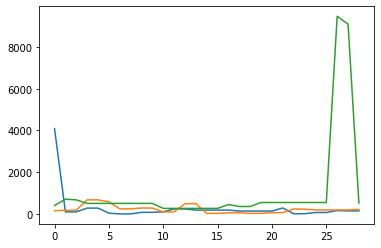

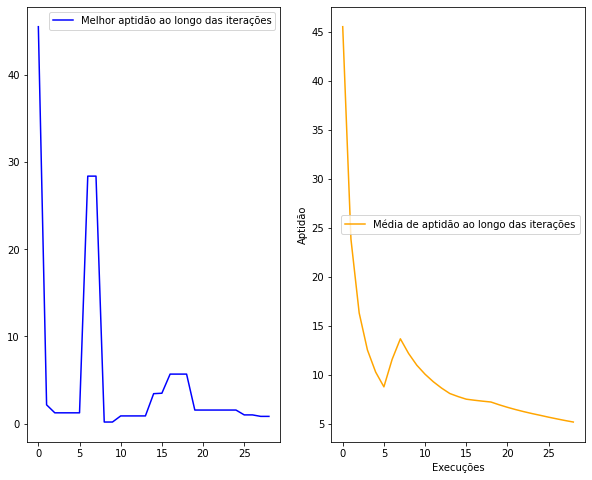

Melhor aptidão 0.34235394195490143
Melhor posição encontrada [0.95314389 0.85016017]
--- 0.552001953125 Segundos ---


In [70]:
executar_pso(3, [(-5, 5), (-5, 5)], [-2, 2], 30)

O teste a princípio foi bastante simples, apenas com 3 partículas no enxame e por 30 iterações. No gráfico acima é possível ver que as partículas passaram a maior parte do tempo próximas umas das outras. 

É possível observar também que a média de aptidão caiu gradativamente ao longo das iterações, o que indica que as partículas convergiram a um valor comum, seguindo a tendência de se aproximarem conforme a melhoria na aptidão. Vale ressaltar que os gráficos exibidos são os que tiveram a melhor aptidão entre as 30 reexecuções.

## Melhorando os resultados
Assim como os demais algoritmos desse gênero, podemos extrair o máximo do seu potencial apenas com o ajuste correto dos parâmetros, nesse caso, o número de indivíduos foi aumentado para 250 e a busca no espaço foi feita por 400 iterações, repetindo 30 vezes cada uma. Além disso, o domínio da velocidade foi diminuído para um intervalo de [-0.5, 0.5] para garantir um "passo" menor na movimentação no espaço de busca, fazendo com que o algoritmo tenha mais chance de atingir o ponto global.

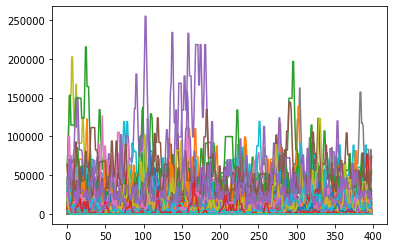

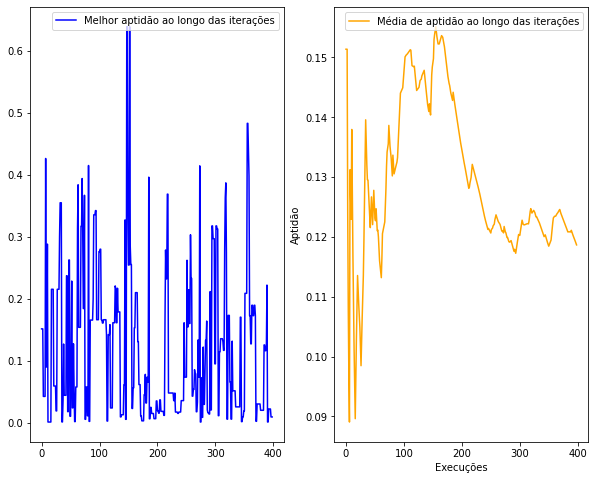

Melhor aptidão 0.009160332585394813
Melhor posição encontrada [0.92166008 0.85495566]
--- 64.01209497451782 Segundos ---


In [71]:
executar_pso(250, [(-5, 5), (-5, 5)], [-0.5, 0.5], 400)

A aptidão obtida pelo algoritmo PSO com esses parâmetros foi bem próxima a 0, fazendo um bom trabalho na otimização do problema. Com um número mais "agressivo" nos parâmetros o tempo de execução ultrapassou um minuto, sendo relativamente alto se comparado à outros algoritmos. Algumas otimizações ainda possíveis de serem realizadas seriam  a alteração da quantidade de partículas na vizinhança, estabelecimento de uma diminuição ainda maior na velocidade das partículas com o passar das iterações e criação de um critério de parada em caso da não obtenção de melhorias para tentar diminuir seu tempo de execução.

# Comparação com os algoritmos genéticos
Foi observado que o PSO conseguiu se sair bem na tarefa anterior de otimização, porém dessa vez, será utilizado o mesmo algoritmo genético proposto no trabalho anterior para otimizar essa mesma fórmula matemática e poder comparar os seus resultados gerais com os resultados que foram obtidos no PSO. 

Todo o código e as funções utilizadas para a implementação do algoritmo genético se encontram abaixo, conforme o último trabalho. Haviam duas versões, uma para valores binários e outra para números escalares, portanto não foi necessário fazer nenhuma modificação específica na implementação do algoritmo genético. O crossover do valor escalar é a sua média e a mutação é um distúrbio aleatório de soma ou subtração. O método escolhido para selecionar os indivíduos para reprodução é o torneio. 

## Função de aptidão
Uma das poucas alterações necessárias foi na função de aptidão, onde é recebido como parâmetro um único valor que é descompactado nos respectivos valores de x e y.

In [72]:
def funcao_aptidao_genetico(valor):
    x = valor[0]
    y = valor[1]
    return (1 - x)**2 + 100*(y-x**2)**2

In [73]:
def mutacao(solucao, dominio):
    constante = 0.05
    index_mutacao = random.randint(0, len(solucao) -1)
    gene_mutado = solucao[index_mutacao]
    solucao = list(solucao)

    if random.random() < 0.5:
        if ((gene_mutado - constante) >= dominio[0][0]):
            gene_mutado = gene_mutado - constante
    else:
        if ((gene_mutado + constante) <= dominio[0][1]):
            gene_mutado = gene_mutado + constante

    del solucao[index_mutacao]
    solucao.insert(index_mutacao, gene_mutado) 
            
    return tuple(solucao)

def crossover(solucao1, solucao2):
    crossed = [(solucao1[i] + solucao2[i]) / 2 for i in range(len(solucao1))]
    return tuple(crossed)

def get_populacao_torneio(populacao, numero_individuos, objetivo, n_competidores = 3):
        nova_populacao = []
        while len(nova_populacao) < numero_individuos:
            torneio = []

            for i in range(n_competidores):
                torneio.append(populacao[random.randint(0, len(populacao) - 1)])
            
            torneio.sort(reverse=objetivo)
            nova_populacao.append(torneio[0][1])
        
        return nova_populacao
    
def get_melhores_individuos(custos, n_elitismo, objetivo):
    custos.sort(reverse=objetivo)
    individuos_ordenados = [individuos for (custo, individuos) in custos]
    elite = individuos_ordenados[0:n_elitismo]
    return elite

def get_populacao(tamanho_populacao, dominio, numeros_inteiros = False):
    populacao = []
    #random.seed(42) #comentar/descomentar para gerar uma seed para os valores "aleatórios"
    for i in range(tamanho_populacao):
        if numeros_inteiros == False:
            solucao = [random.uniform(dominio[i][0], dominio[i][1]) for i in range(
                len(dominio))]
        else:
            solucao = [random.randint(dominio[i][0], dominio[i][1]) for i in range(
                len(dominio))]
        
        populacao.append(tuple(solucao)) 
        
    return populacao

def genetico(funcao_custo, dominio, objetivo = False, tamanho_populacao = 16, p_mutacao = 0.1, 
               elitismo = 0.1, geracoes=12, binario = True):
    
    populacao = get_populacao(tamanho_populacao, dominio, binario)
    media_custo_final = []
    custos_medios = []
    custo_minimo = []
    numero_elitismo = int(elitismo * tamanho_populacao)
    for i in range(geracoes):
        custos = [(funcao_custo(individuo), individuo) for individuo in populacao]
        
        populacao = get_melhores_individuos(custos, numero_elitismo, objetivo) 
    
        individuos_escolhidos = get_populacao_torneio(custos, (
                                tamanho_populacao // 2) - numero_elitismo, objetivo)
               
        while len(populacao) < tamanho_populacao:
            if random.random() < p_mutacao:
                individuo_selecionado = random.randint(0, len(individuos_escolhidos) -1)
                f_mutacao = mutacao_binaria if binario == True else mutacao
                populacao.append(f_mutacao(individuos_escolhidos[individuo_selecionado], 
                                          dominio))
            else:
                individuo1 = random.randint(0, len(individuos_escolhidos) -1)
                individuo2 = random.randint(0, len(individuos_escolhidos) -1)
                f_crossover = crossover_binario if binario == True else crossover 
                populacao.append(f_crossover(individuos_escolhidos[individuo1], 
                                           individuos_escolhidos[individuo2]))
        
        custo_final = [custo[0] for custo in custos]
        custo_minimo.append(min(custo_final))
        media_custo_final.append(sum(custo_final) / len(custo_final))
    
    return custos[0][0], custos[0][1], media_custo_final, custo_minimo

## Realização dos testes
Após preparação de todo o código, basta refazer a lógica conforme a anterior para reexecutar o algoritmo genético 30 vezes e capturar seu desempenho em diferentes inicializações, mostrando os melhores resultados ao final.

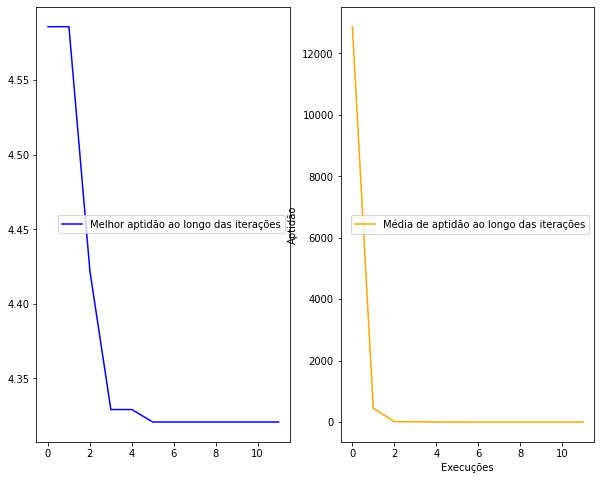

Melhor aptidão 0.001928506028998196
Melhor posição encontrada (0.95725903832325, 0.915336321837048)
--- 0.3487873077392578 Segundos ---


In [74]:
custos = []
solucao = []
melhor_aptidao = 9999
dominio = [(-5, 5), (-5, 5)]
start_time = time.time()
media_custo = []

#Objetivo true para maximizar e false para minimizar
for i in range(30):
    solucao_algoritmo_genetico = genetico(funcao_aptidao_genetico, dominio, False, binario=False)
    solucao = solucao_algoritmo_genetico[1] if solucao_algoritmo_genetico[0] <= melhor_aptidao else solucao
    custos.append(solucao_algoritmo_genetico[0])
    media_custo = solucao_algoritmo_genetico[2] if solucao_algoritmo_genetico[0] <= melhor_aptidao else media_custo
    melhor_aptidao = solucao_algoritmo_genetico[0] if solucao_algoritmo_genetico[0] <= melhor_aptidao else melhor_aptidao
  
# exibindo os resultados fiansi
exibir_convergencia_minima_media(solucao_algoritmo_genetico[3], media_custo)
print('Melhor aptidão', melhor_aptidao)
print('Melhor posição encontrada', solucao)
print("--- %s Segundos ---" % (time.time() - start_time))

Os resultados mostram uma superioridade interessante dos algoritmos genéticos sobre o PSO dada essas circunstâncias. Utilizando apenas 16 indivíduos na população sendo evoluídos por 12 gerações foi possível obter resultados superiores ao algoritmo anterior, conseguindo uma maior aproximação do 0.

Além disso, o tempo de execução foi de menos de um segundo, sendo mais de 60 vezes mais rápido que a otimização por enxame de partículas. Podemos ver também através dos gráficos de menor valor e média uma estabilidade maior na convergência do algoritmo.

## Conclusões
Inúmeros estudos ainda são realizados utilizando algoritmos de otimização por partículas, sendo a versão aqui implementada apenas uma delas.
Sua inspiração biológica e também funcionamento é mais simples se comparado aos algoritmos genéticos que envolvem não só reprodução genética como também evolução darwiniana e mutação (além do elitismo que não é diretamente da natureza). Ainda assim, o PSO mostrou um bom funcionamento de sua proposta, conseguindo bons resultados na otimização quando criamos de fato um enxame (grande quantidade) de partículas. Foi observado todavia, que esse enxame, ainda que efetivo, gera uma instabilidade maior no modelo além de exigir mais tempo de processamento. 

Por conta disso, os algoritmos genéticos provavelmente são mais efetivos em propósito geral, pois o uso de técnicas como o crossover para troca de informação entre indivíduos e a mutação para exploração do espaço garantem uma robustes do algoritmo sem exigir um tempo de processamento maior por isso.

# Qual o problema?
No segundo problema, a ideia é utilizar o algoritmo *ant colony optimization (ACO)*  para encontrar o melhor caminho entre as cidades, seguindo algo parecido com o problema do caixeiro viajante.

## Criação do conjunto de dados
O arquivo disponibilizado originalmente estava no formato '.tsp', porém o mesmo foi convertido para o formato '.csv' e foram acrescidos as colunas de 'index', 'x' e 'y', representando o código da cidade e suas coordenadas no espaço. 

Após essa conversão, o arquivo pode ser lido utilizando o método *read_csv* da biblioteca do *pandas* para ser transformado assim em um dataframe, que por sua vez permite a criação de querys e manipulações nos dados que serão úteis na execução do algoritmo.

In [3]:
dataframe = pd.read_csv('/home/alvaro/Documentos/mestrado/computação bio/algoritmos-otimizacao/dataset/berlin.csv')

## Função de aptidão
A aptidão da solução é dada pela distância Euclidiana dos pontos no espaço e sua implementação foi realizada no método *get_distancia_entre_pontos*, onde as coordenadas x e y das duas cidades são recebidas como parâmetros e a fórmula da distância é então aplicada.

In [4]:
def get_distancia_entre_pontos(cidade1, cidade2): # distância euclidiana 
    diferenca_coord = (cidade1[0] - cidade2[0])**2 + (cidade1[1] - cidade2[1])**2
    distancia = math.sqrt(diferenca_coord) # Raiz quadrada 
    return distancia

## Definindo vértices e arestas
Problemas desse tipo são representados por grafos, estruturas de vértices e arestas, que nesse caso são as cidades e os caminhos que ligam as cidades respectivamente.
Para criar uma representação de todas as vértices bem como os possíveis caminhos(arestas) entre cada uma delas foi criado o método *get_dicionario_cidades*, que recebe como parâmetro uma combinação permutada de todas as cidades e cria as arestas entre elas.

Esse método gera como retorno um dicionário onde as arestas são as chaves e os feromônios artificiais os valores. Os feromônios são iniciados com um valor de 10e-6 conforme sugerido. 

Esse método permite uma manipulação mais simples das rotas a serem percorridos pelas formigas pois mapeia todos os possíveis caminhos, porém pode se tornar um pouco custoso computacionalmente se o número de cidades existentes aumentar muito.

In [5]:
def get_dicionario_cidades(combinacao_cidades):
    cidades = {}
    for i in combinacao_cidades:
        cidades[i] = [0.000001] # quantidade inicial (sugerida) de feromônios

    return cidades

## Iniciando a colônia
A inicialização da colônia de formigas se deu pelo método *iniciar_colonia_aleatoria* que recebe o número de formigas da colônia, o número de cidades presentes no conjunto e também uma semente geradora para os valores aleatórios.
Em cada iteração do algoritmo as formigas são reiniciadas em uma nova cidade, uma vez que uma semente diferente é usada. A cidade de inicio é um valor aleatório atribuído para cada formiga, respeitando o domínio de cidades, que nesse caso é entre 1 a 52, por ser a quantidade de cidades existentes no conjunto.

In [6]:
def iniciar_colonia_aleatoria(n_formigas, n_cidades, seed):
    colonia = []
    random.seed(seed)

    for i in range(n_formigas):
        colonia.append([(random.randint(1, n_cidades),)])

    return colonia

Outros testes foram realizados com uma inicialização não aleatória, para simular um ponto comum como sendo a origem/formigueiro de todas as formigas, como é possível ver no método *iniciar_colonia*. Porém foi observado que com essa abordagem o algoritmo não foi capaz de convergir, mantendo um valor fixo em todas as iterações. 

Isso faz sentido pois as formigas acabam se prendendo a uma rota comum, devido ao fato de possuírem as mesmas probabilidades de vizinhança. Isso se reforça com o passar das iterações por conta do estímulo de feromônios, fazendo com que elas tenham um único caminho. A alteração dos parâmetros do algoritmo para favorecer a exploração poderia melhorar esse aspecto, mas a inicialização aleatória já foi efetiva. 

In [7]:
def iniciar_colonia(n_formigas):
    colonia = []

    for i in range(n_formigas):
        colonia.append([(1,)])

    return colonia

## Verificando a vizinhança
Cada formiga precisa se orientar no espaço, para que seja capaz de tomar uma decisão em relação a seu próximo movimento. Para isso, foi utilizado o método *get_distancia_cidades_vizinhas*, cujo objetivo é verificar todos os vizinhos de todas as formigas. Assim, o primeiro passo é excluir da lista de cidades aquelas em que a formiga em questão já visitou, pois ela armazena essa informação em memória. Após isso, para cada uma das cidades restantes o método de *get_distancia_entre_pontos* é usado calcular a distância Euclidiana entre a cidade atual da formiga e todas as outras vizinhas.
Uma otimização possível de ser realizada aqui é considerar um limite de vizinhança, pois em problemas com um número maior de cidades, calcular a vizinhança e a probabilidade de movimento de cada uma delas pode ser muito demorado além de perder um pouco o sentido em pontos muito distantes uns dos outros, já que a propabilidade de movimentação é mínima devido à baixa visibilidade.

O retorno desse método é uma lista para cada formiga com todos os seus vizinhos e suas respectivas distâncias.

In [8]:
def get_distancia_cidades_vizinhas(formigas, dataframe):
    distancias = []

    for i in formigas:
        coordenadas_formiga = dataframe[dataframe['index'] == i[-1][-1]].values # pega a posição atual da formiga
        
        removed_cities = list(map(lambda x: x[-1], i)) # Listando as cidades que ela já visitou
        df_cidades = dataframe[~dataframe['index'].isin(removed_cities)].values # removendo as cidades que a formiga já visitou

        distancia_formiga = {}      
        
        for vizinho in df_cidades:  # para cada cidade, calcula a distância do ponto atual da formiga e a cidade              
            distancia_formiga[(i[-1][-1], int(vizinho[0]))] = get_distancia_entre_pontos([coordenadas_formiga[0][1], \
                                coordenadas_formiga[0][2]], [vizinho[1], vizinho[2]])

        distancias.append(distancia_formiga)

    return distancias # retorna a distância de todas as cidades vizinhas de cada uma das formigas

## Escolhendo probabilisticamente a melhor cidade
Após concluído o cálculo da distância das cidades é preciso escolher o próximo movimento que cada uma das formigas irá fazer, utilizando o método *get_proximo_movimento*.
Nesse método, para cada formiga é calculado a probabilidade de movimento, utilizando um método auxiliar chamado *calcular_probabilidade_movimento*. Para realização do cálculo, é utilizado a lista de distância de cidades que foi gerada anteriormente, onde para cada cidade obtemos o inverso da distância (visibilidade) multiplicado à quantidade de feromônios.

Feito isso, a probabilidade resultante é dividida pela soma de todas as probabilidades e a cidade mais provável é extraída através de método *.argmax()* do *numpy*.
Dessa forma, para cada formiga, é armazenado o seu próximo movimento, baseado na cidade de maior probabilidade bem como a distância Euclidiana que será percorrida nesse próximo movimento.
As distância percorridas são armazenadas em cada iteração para que sejam simplesmente somadas ao final do algoritmo, revelando a aptidão da rota que foi criada pela formiga.

In [9]:
def calcular_probabilidade_movimento(distancia, arestas_cidades, alfa, beta):
    probabilidades = []

    for cidade in distancia: # calcula a probabilidade de se mover para a cidade
        inverso_distancia = 1 / distancia[cidade]
        
        p = (arestas_cidades[cidade][0]**alfa) * (inverso_distancia**beta)
        probabilidades.append(p)

    return probabilidades

In [10]:
def get_proximo_movimento(distancia_cidades_vizinhas, arestas_cidades, alfa=1, beta=5):
    proximos_movimentos = []
    distancias_percorridas = []
    
    for distancia in distancia_cidades_vizinhas:
        # calcula prob de cada cidade
        probabilidades = calcular_probabilidade_movimento(distancia, arestas_cidades, alfa, beta)
        # divide a probabilidade pela soma
        proba_cidade = np.array(probabilidades) / sum(probabilidades) 
        # pega a cidade com a maior P
        cidade_mais_proxima = list(distancia.keys())[proba_cidade.argmax()] 
        # registra o próximo movimento da formiga
        proximos_movimentos.append(cidade_mais_proxima) 
        # registra a distância percorrida do próximo movimento
        distancias_percorridas.append(distancia[cidade_mais_proxima]) 
               
    return proximos_movimentos, distancias_percorridas

## Movimentando as formigas
O método de *movimentar_formigas* tem por simples objetivo aplicar a movimentação entre cidades que foi definida anteriormente para cada formiga.

In [11]:
def movimentar_formigas(formigas, movimento_formigas):
    for i in range(len(formigas)):
        formigas[i].append(movimento_formigas[i]) # aplica a movimentação da formiga

    return formigas

## Atualização de feromônios
O processo descrito até aqui é repetido enquanto houverem movimentos possíveis a serem feitos pelas formigas, sendo finalizado apenas quando todas as cidades já foram visitadas, formando assim uma rota completa construída por cada formiga. 

O próximo passo é atualizar os feromônios, no método *atualizar_fenomonios*. Um dos parâmetros que esse método recebe é a distancia total que cada formigas caminhou, sendo esse a aptidão da sua rota, utilizada para calcular a quantidade de feromônios que a formiga irá depositar nas arestas em que passou. Como cada formiga possui em sua memória as erestas visitadas, basta acrescentar iterativamente o valor de feromônios no dicionário de arestas de cidades que foi criado anteriomente através da combinação de todas as arestas.

Os demais valores de esquecimento para "evaporar" o feromônio e também o elitismo foram mantidos iguais aos exemplos do slide e são considerados nos cálculos para definir a quantidade de feromônio depositado.

In [12]:
def atualizar_feromonios(formigas, distancia_total_formigas, arestas_cidades, Q=100, p=0.5, b=5):
    count = 0
    for formiga in formigas:
        formiga = formiga[1:len(formiga)-1]
        for aresta in formiga:
            # calcula a quantidade de feromônios
            feromonios_depositados = Q / distancia_total_formigas[count] 

            # calcula a quantidade de feromônios para a formiga com melhor caminho
            feromonio_formiga_elitista = b*feromonios_depositados if \
                min(distancia_total_formigas) == distancia_total_formigas[count] else 0

            # aplica os feromônios nas arestas que compõe a rota.
            arestas_cidades[aresta] += \
                [(1 - p) * arestas_cidades[aresta][0] + feromonios_depositados + feromonio_formiga_elitista]

        count += 1

    return arestas_cidades 

Ao final de cada iteração, também é armazenado a melhor distância, distância média e a melhor rota das formigas. Podemos imaginar que os feromônios representam o aprendizado desse algoritmo, pois a única coisa que muda além de um novo sorteio aleatório das formigas pelas cidades é a atualização da quantidade de feromônio em cada aresta, reforçando alguns caminhos e também inibindo outros.

## Aplicação do ACO
O método *aco* é o que irá fazer a aplicação de fato de todos os métodos criados anteriormente, recebendo como parâmetro o número de formigas que será utilizada, o conjunto de dados e a quantidade de "épocas" ou iterações do algoritmo.

In [13]:
def aco(n_formigas, dataframe, epocas = 5):
    # combinação de todas as cidades possíveis
    combinacao_cidades = list(itertools.permutations(dataframe['index'].values, 2))

    # criação das arestas/caminhos possíveis
    arestas_cidades = get_dicionario_cidades(combinacao_cidades)

    # melhores valores
    melhor_distancia = []
    distancia_media = []
    melhor_caminho = []

    for i in range(epocas):
        execucoes = 0
        formigas = iniciar_colonia_aleatoria(n_formigas, len(dataframe) - 1, random.randint(0, 100))
        distancia_total_formigas = [0] * n_formigas # inicializa a distância percorrida por cada formiga
               
        while execucoes < len(dataframe) -1:    
            distancia_cidades_vizinhas = get_distancia_cidades_vizinhas(formigas, dataframe)
            
            movimento_formigas, distancia_percorrida = get_proximo_movimento(distancia_cidades_vizinhas, arestas_cidades)
                
            formigas = movimentar_formigas(formigas, movimento_formigas)
            
            # soma a distância total de cada formiga (aptidão da rota)
            distancia_total_formigas = list(map(lambda x, y: x + y, distancia_total_formigas, distancia_percorrida))

            execucoes += 1
        
        # atualiza os feromônios das arestas
        arestas_cidades = atualizar_feromonios(formigas, distancia_total_formigas, arestas_cidades) # atualizar a lista de feromônios
        
        # salva os melhores valores
        melhor_distancia.append(min(distancia_total_formigas)) 
        distancia_media.append(sum(distancia_total_formigas) / len(distancia_total_formigas))
        melhor_caminho = formigas[distancia_total_formigas.index(min(distancia_total_formigas))]

    return melhor_distancia, melhor_caminho, distancia_media

## Visualização dos resultados
Para visualizar os resultados gerados pelo algoritmo, foram criados os métodos de *get_coordenadas_melhor_rota* e *mostrar_grafico_resultados*. O primeiro, como o nome sugere, extrai as coordenadas x e y de todas as cidades que compôe a melhor rota encontrada pelas formigas. Essa lista de coordenadas é utilizada então no segundo método que plota não só as cidades no gráfico de dispersão sendo representadas por pontos azuis como também cria uma linha vermelha represetando a melhor rota encontrada.

In [14]:
def get_coordenadas_melhor_rota(dataframe, melhor_caminho):
    melhor_x = []
    melhor_y = []
    for caminho in melhor_caminho:
        cidade_inicial = dataframe[dataframe['index'] == caminho[0]]
        melhor_x.append(cidade_inicial['x'].values[0])
        melhor_y.append(cidade_inicial['y'].values[0])

        if len(caminho) == 2:
            cidade_final = dataframe[dataframe['index'] == caminho[1]]
            melhor_x.append(cidade_final['x'].values[0])
            melhor_y.append(cidade_final['y'].values[0])

    return melhor_x, melhor_y

def mostrar_grafico_resultados(dataframe, melhor_x, melhor_y):
    plt.scatter(dataframe['x'].values, dataframe['y'].values)
    plt.plot(melhor_x, melhor_y, '.r-') 
    plt.show()

## Excutando o algoritmo
Por fim, o algoritmo foi reexecutado 5 vezes ao invés das 30 dos algoritmos anteriores, pelo fato do ACO ter um tempo de execução ainda maior. A criação individual de rotas pelas formigas permite uma paralelização do processo, gerando uma redução no tempo de execução, porém isso exigiria algumas mudanças na arquitetura do código, como uma instanciação em multiprocessos da CPU, porém uma vez que o objetivo era apenas implementar o algoritmo e resolver o problema de escala simples, isso não foi necessário.


Em cada reexecução, o ACO executou por 5 épocas/iterações, também sendo um número pequeno, todavia foi visto que aumentar esse valor não agregou em uma melhoria dos resultados, pois logo na primeira interação a melhor rota já foi descoberta. 


Em cada reexecução do código, os melhores valores de distância e rotas foram armazenados para serem exibidos nos métodos anteriormente criados.

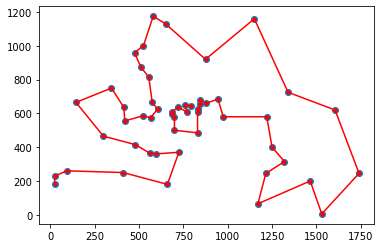

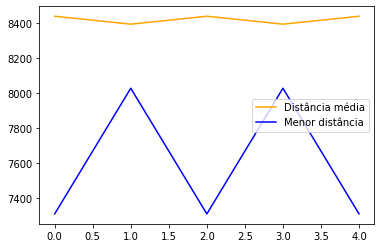

Melhor distância 7310.669644787184
Distância média 8394.551019680055
--- 88.71097254753113 Segundos ---


In [19]:
def executar_aco(reexecucoes, iteracoes):
    melhor_distancia, melhor_caminho, distancia_media = [99999],[(0)],[99999]
    start_time = time.time()

    for i in range(reexecucoes):
        resultado_aco = aco(51, dataframe, iteracoes)
        # armazenando os melhores resultados
        distancia_media = resultado_aco[2] if min(resultado_aco[0]) < min(melhor_distancia) else distancia_media
        melhor_caminho = resultado_aco[1] if min(resultado_aco[0]) < min(melhor_distancia) else melhor_caminho
        melhor_distancia = resultado_aco[0] if min(resultado_aco[0]) < min(melhor_distancia) else melhor_distancia

    # pegando as melhores coordenadas
    melhor_x, melhor_y = get_coordenadas_melhor_rota(dataframe, melhor_caminho)
    # exibindo a melhor rota
    mostrar_grafico_resultados(dataframe, melhor_x, melhor_y)
    # exibindo os gráficos de média de custo e custo mínimo
    plt.plot(distancia_media, color = 'orange')
    plt.plot(melhor_distancia, color = 'blue')
    plt.legend(['Distância média', 'Menor distância'])
    plt.show()

    print('Melhor distância', min(melhor_distancia))
    print('Distância média', min(distancia_media))
    print("--- %s Segundos ---" % (time.time() - start_time))

executar_aco(5, 5)

## Avaliando os resultados
Como foi dito, logo na primeira iteração o algoritmo encontrou a menor rota. Pelo desconhecimento do mínimo global, não posso dizer se essa é a menor rota possível, mas foi a que o algoritmo ficou preso em todas as reexecuções, com um custo total de 7310, representando a soma das distâncias Euclidianas de todas as cidades.


É possível observar no caminho exibido em vermelho, que a rota encontrada parece ser suficientemente boa para resolver o problema em questão, pois não há nenhum cruzamento ou caminho que possa ser aparentemente melhorado, levando a crer que a solução é boa o bastante.

O custo médio e mínimo seguiram uma oscilação semelhante em diferentes reexecuções, indicando que para obter novos resultados seria provavelmente necessário fazer um ajuste fino de parâmetros.

Vale lembrar que todos os parâmetros utilizados foram os sugeridos em aula, sendo possível tentar buscar melhores resultados ao modificar os parâmetros em questão, inclusive utilizar algoritmos genéticos para isso seria uma abordagem bastante válida. 

O fato de logo na primeira interação o melhor resultado conhecido já ser encontrado possivelmente se deve ao número de formigas na colônia, permitindo uma exploração abragente pelo espaço. Um ponto de atenção todavia é que o aumento da quantidade de formigas também aumenta consideravelmente o tempo de execução pelo fato da aumentar as rotas criadas em cada iteração. 

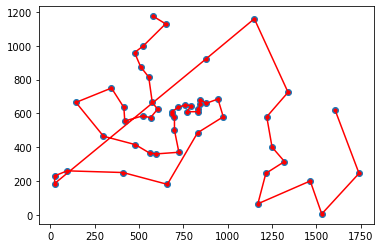

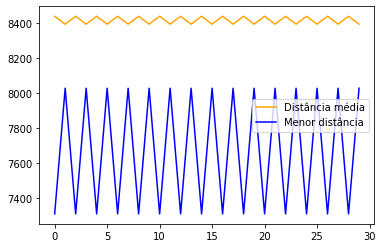

Melhor distância 7310.669644787184
Distância média 8394.551019680055
--- 108.26997685432434 Segundos ---


In [18]:
executar_aco(1, 30)

Ao testar o algoritmo por 30 iterações, fica claro pela distância mínima e média que a rota está estagnada no valor de 7310, porém dessa vez um caminho um pouco diferente foi encontrado, com curiosamente a mesma distância Euclidiana.

# Conclusões
O algoritmo ACO se mostrou uma ótima abordagem para resolver o problema do caixeiro viajante, conseguindo em menos de 2 minutos uma solução extremamente satisfatória. Diversos estudos ainda são realizados e melhorias implementadas que geram ainda mais possibilidades, principalmente em problemas mais complexos. A quantidade de parâmetros também deixa o algoritmo robusto e versátil para conseguir resolver outros problemas, ainda mais se considerado a paralelização da construção dos caminhos, para garantir a eficiência computacional.